Raw columns: ['price date', 'modal price (rs./quintal)']
Using date column: 'price date'
Using price column: 'modal price (rs./quintal)'
Rows before dropna: 1801
Rows after dropna: 1801


,date,price_raw,price
0,2020-01-01,2038.0,2038.0
1,2020-01-02,2475.0,2475.0
2,2020-01-03,2500.0,2500.0
3,2020-01-04,2564.0,2564.0
4,2020-01-05,2564.0,2564.0


Inferred frequency: D
Series length: 1801 Start: 2020-01-01 00:00:00 End: 2024-12-05 00:00:00
Train length: 1621 Test length: 180
Starting small ARIMA grid search (this may take a minute)...
 tried order (0, 0, 0) -> AIC 30854.2
 tried order (0, 0, 1) -> AIC 29949.2
 tried order (0, 0, 2) -> AIC 28881.5
 tried order (0, 1, 0) -> AIC 27628.9
 tried order (0, 1, 1) -> AIC 26633.5
 tried order (0, 1, 2) -> AIC 26624.5
 tried order (1, 0, 0) -> AIC 27590.5
 tried order (1, 0, 1) -> AIC 26686.9
 tried order (1, 0, 2) -> AIC 26645.9
 tried order (1, 1, 0) -> AIC 27182.7
 tried order (1, 1, 1) -> AIC 26632.4
 tried order (1, 1, 2) -> AIC 26618.7
 tried order (2, 0, 0) -> AIC 27165.1
 tried order (2, 0, 1) -> AIC 26686.3
 tried order (2, 0, 2) -> AIC 26649.5
 tried order (2, 1, 0) -> AIC 26993.0
 tried order (2, 1, 1) -> AIC 26632.4
 tried order (2, 1, 2) -> AIC 26620.6
Best order by AIC: (1, 1, 2) AIC: 26618.671328043944
                               SARIMAX Results                          

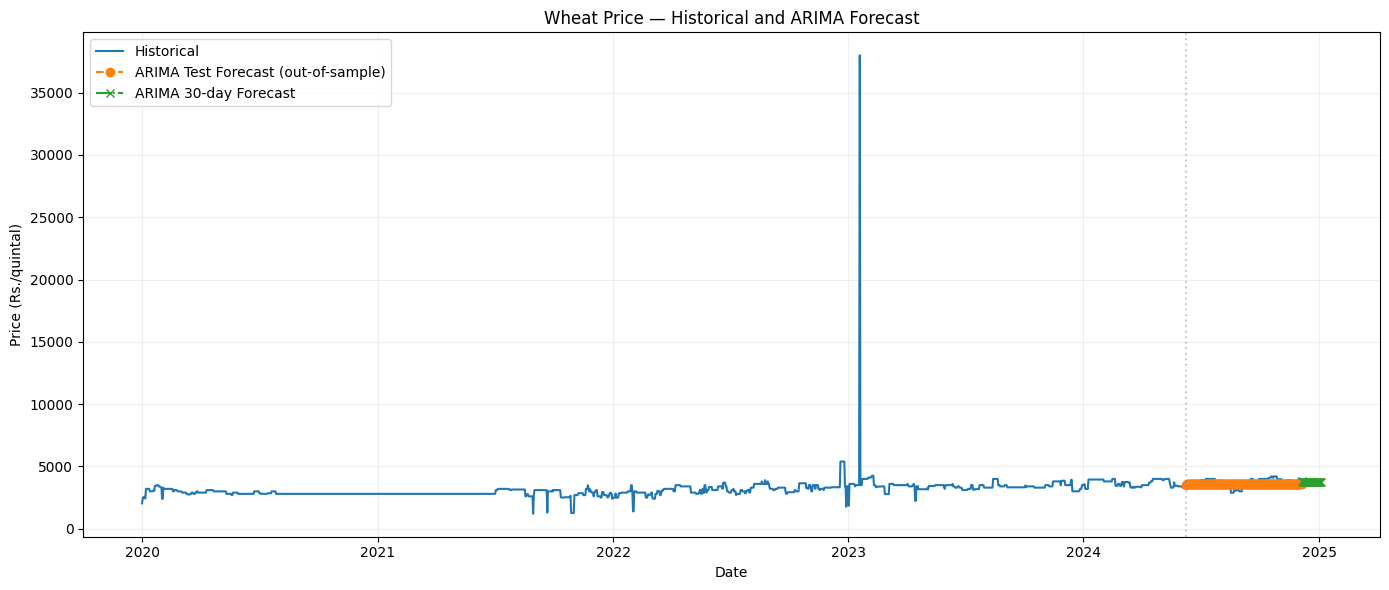

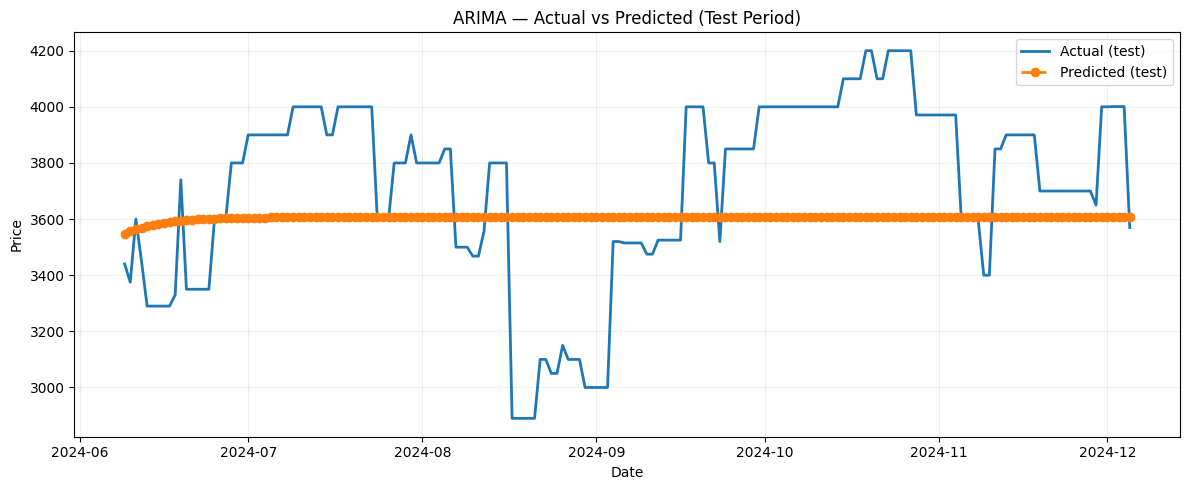


Next 7-day forecast:
2024-12-06    3792.13
2024-12-07    3789.24
2024-12-08    3786.66
2024-12-09    3784.35
2024-12-10    3782.29
2024-12-11    3780.45
2024-12-12    3778.81
Freq: D, Name: predicted_mean, dtype: float64

Next 30-day forecast (first 10 rows shown):
2024-12-06    3792.13
2024-12-07    3789.24
2024-12-08    3786.66
2024-12-09    3784.35
2024-12-10    3782.29
2024-12-11    3780.45
2024-12-12    3778.81
2024-12-13    3777.34
2024-12-14    3776.03
2024-12-15    3774.86
Freq: D, Name: predicted_mean, dtype: float64


In [3]:
# ARIMA / SARIMAX full script — paste into a notebook (works with your CSV header)
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

from statsmodels.tsa.statespace.sarimax import SARIMAX

# ---------------------
# Config / filepath
# ---------------------
csv_path = "wheat_Mysore_daily.csv"   # change if needed
date_candidates = ["date", "price date", "price_date", "date_price", "price date "]  # heuristic names
price_candidates = ["price", "modal price (rs./quintal)", "modal price", "modal", "price (rs./quintal)"]

# ---------------------
# Load & robust parsing
# ---------------------
df_raw = pd.read_csv(csv_path, dtype=str, encoding='utf-8', keep_default_na=False)
print("Raw columns:", df_raw.columns.tolist())

# Heuristic detection of date and price columns
date_col = None
price_col = None
for c in df_raw.columns:
    low = c.strip().lower()
    if any(x in low for x in ["date"]):
        date_col = c
    if any(x in low for x in ["price", "modal", "quintal"]):
        price_col = c

# Fallback: first two columns if not detected
if date_col is None:
    date_col = df_raw.columns[0]
if price_col is None:
    price_col = df_raw.columns[1] if len(df_raw.columns) > 1 else df_raw.columns[0]

print("Using date column:", repr(date_col))
print("Using price column:", repr(price_col))

# Clean and convert
df = df_raw[[date_col, price_col]].copy()
df.columns = ["date", "price_raw"]
# strip spaces
df['date'] = df['date'].astype(str).str.strip()
df['price_raw'] = df['price_raw'].astype(str).str.strip()

# remove thousands separators and non-numeric junk from price
df['price'] = df['price_raw'].str.replace(',', '', regex=False) \
                               .str.replace(r'[^\d\.\-]', '', regex=True)
# parse numeric and dates, drop invalid rows
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)

print("Rows before dropna:", len(df))
df = df.dropna(subset=['date', 'price']).sort_values('date').reset_index(drop=True)
print("Rows after dropna:", len(df))
display(df.head())

# set index
df.set_index('date', inplace=True)
series = df['price'].asfreq(None)  # keep as-is; we'll set freq next

# ---------------------
# Ensure regular frequency (daily by default)
# ---------------------
# Try to infer freq; if None, reindex to daily and forward-fill (or interpolate)
inferred = pd.infer_freq(series.index)
print("Inferred frequency:", inferred)

if inferred is None:
    # choose desired freq - adjust if your data is monthly/weekly
    target_freq = 'D'   # daily
    print(f"Setting frequency to {target_freq} and forward-filling missing dates (if any).")
    # reindex to daily and fill missing using forward-fill then backfill if needed
    full_idx = pd.date_range(start=series.index.min(), end=series.index.max(), freq=target_freq)
    series = series.reindex(full_idx)
    # simple filling strategy — you can change to interpolation if preferred
    series = series.fillna(method='ffill').fillna(method='bfill')
    series.index.name = 'date'
else:
    # ensure series has freq attribute
    series = series.asfreq(inferred).fillna(method='ffill').fillna(method='bfill')

print("Series length:", len(series), "Start:", series.index.min(), "End:", series.index.max())

# ---------------------
# Train/test split (time-based)
# ---------------------
horizon_short = 7
horizon_long = 30
test_ratio = 0.10
n_test = max(int(len(series) * test_ratio), max(horizon_short, 1))
train = series.iloc[:-n_test]
test = series.iloc[-n_test:]

print("Train length:", len(train), "Test length:", len(test))

# ---------------------
# Small grid search for ARIMA(p,d,q) by AIC (keeps it lightweight)
# ---------------------
import itertools
p_range = range(0, 3)   # try p = 0..2
d_range = range(0, 2)   # d = 0..1
q_range = range(0, 3)   # q = 0..2

best_aic = np.inf
best_order = None
best_model_res = None

print("Starting small ARIMA grid search (this may take a minute)...")
for p, d, q in itertools.product(p_range, d_range, q_range):
    try:
        mod = SARIMAX(train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
        res = mod.fit(disp=False, method='lbfgs', maxiter=200)
        aic = res.aic
        # print progress minimally
        print(f" tried order {(p,d,q)} -> AIC {aic:.1f}")
        if aic < best_aic:
            best_aic = aic
            best_order = (p,d,q)
            best_model_res = res
    except Exception as e:
        # skip non-converging combinations
        # print(" skip", (p,d,q), "err:", e)
        continue

if best_model_res is None:
    raise RuntimeError("No ARIMA model converged — consider expanding ranges or pre-differencing/transforming data.")

print("Best order by AIC:", best_order, "AIC:", best_aic)

# ---------------------
# Fit final model on full train (best found)
# ---------------------
final_order = best_order
model = SARIMAX(train, order=final_order, enforce_stationarity=False, enforce_invertibility=False)
result = model.fit(disp=False)
print(result.summary())

# ---------------------
# Forecasting
# ---------------------
# 1) Forecast on test period (out-of-sample)
pred_test = result.get_forecast(steps=len(test))
y_pred_test = pred_test.predicted_mean
y_pred_test.index = test.index  # align index

# 2) Forecast next horizon_short and horizon_long from the last available date (iterative or direct)
# Forecast horizon_long steps from entire series (re-fit on full series optional)
model_full = SARIMAX(series, order=final_order, enforce_stationarity=False, enforce_invertibility=False)
res_full = model_full.fit(disp=False)
future_forecast = res_full.get_forecast(steps=horizon_long)
future_mean = future_forecast.predicted_mean
future_index = pd.date_range(start=series.index[-1] + pd.Timedelta(days=1), periods=horizon_long, freq=series.index.freq or 'D')
future_mean.index = future_index

pred_7 = future_mean[:horizon_short]
pred_30 = future_mean

# ---------------------
# Evaluation metrics on test split
# ---------------------
y_true = test.values
y_pred = y_pred_test.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nTest MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R^2: {r2:.4f}")

# ---------------------
# Save model + scalars if desired
# ---------------------
os.makedirs('models_arima', exist_ok=True)
result.save('models_arima/arima_best_train.pkl')   # fitted on train
res_full.save('models_arima/arima_full.pkl')       # fitted on full series
print("Saved model artifacts to models_arima/")

# ---------------------
# Plots
# ---------------------
plt.figure(figsize=(14,6))
plt.plot(series.index, series.values, label='Historical', linewidth=1.5)
plt.plot(test.index, y_pred, label='ARIMA Test Forecast (out-of-sample)', linestyle='--', marker='o')
plt.plot(future_mean.index, future_mean.values, label=f'ARIMA {horizon_long}-day Forecast', linestyle='-.', marker='x')
plt.axvline(series.index[-len(test)], color='gray', alpha=0.4, linestyle=':')
plt.title("Wheat Price — Historical and ARIMA Forecast")
plt.xlabel("Date")
plt.ylabel("Price (Rs./quintal)")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Zoomed actual vs predicted on test window
plt.figure(figsize=(12,5))
plt.plot(test.index, y_true, label='Actual (test)', linewidth=2)
plt.plot(test.index, y_pred, label='Predicted (test)', linewidth=2, linestyle='--', marker='o')
plt.title("ARIMA — Actual vs Predicted (Test Period)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

# Print short tables for predicted next days
print("\nNext 7-day forecast:")
print(pred_7.round(2))
print("\nNext 30-day forecast (first 10 rows shown):")
print(pred_30.round(2).head(10))
